In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
# GPU setting
# 由于 batch_size = 1 因此只能使用一块 GPU 进行训练，因此这里指定仅使用 第一块 GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# 默认情况下 GPU 显存是完全使用的，在这里将 GPU 的显存使用情况设置为动态申请
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = tf.Session(config=gpu_config)
KTF.set_session(session)

Using TensorFlow backend.


<a id='session1'></a>
## Generate data

In [2]:
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
%matplotlib inline
import os
import copy
from data_util import parse_bj_aq_data, generate_train_dev_set
from data_util import generate_training_data_for_seq2seq, generate_dev_data_for_seq2seq
from metrics import symmetric_mean_absolute_percentage_error

In [3]:
# data
bj_aq_data, stations, bj_aq_stations, bj_aq_stations_merged = parse_bj_aq_data()

NaN in PM2.5 is 23459, 6.508615 %
NaN in PM10 is 96175, 26.683406 %
NaN in NO2 is 21720, 6.026135 %
NaN in CO is 46144, 12.802486 %
NaN in O3 is 23732, 6.584358 %
NaN in SO2 is 21664, 6.010598 %
There are 35 air quality stations in Beijing

The stations in Beijing are:
 {'xizhimenbei_aq', 'fengtaihuayuan_aq', 'wanshouxigong_aq', 'badaling_aq', 'guanyuan_aq', 'yizhuang_aq', 'gucheng_aq', 'nansanhuan_aq', 'liulihe_aq', 'yanqin_aq', 'dingling_aq', 'shunyi_aq', 'mentougou_aq', 'yungang_aq', 'daxing_aq', 'yufa_aq', 'pingchang_aq', 'pinggu_aq', 'beibuxinqu_aq', 'dongsihuan_aq', 'tongzhou_aq', 'yongdingmennei_aq', 'donggaocun_aq', 'tiantan_aq', 'huairou_aq', 'qianmen_aq', 'miyun_aq', 'wanliu_aq', 'miyunshuiku_aq', 'dongsi_aq', 'yongledian_aq', 'aotizhongxin_aq', 'nongzhanguan_aq', 'fangshan_aq', 'zhiwuyuan_aq'}


/notebooks/KDD_Cup_2018/data_util.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("utc_time", axis=1, inplace=True)
/notebooks/KDD_Cup_2018/data_util.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("stationId", axis=1, inplace=True)


- generate data functions
    - function `generate_training_data_for_seq2seq()` and `generate_dev_data_for_seq2seq()` are different
    - `generate_training_data_for_seq2seq()` randomly generate batch_size training data at a time
    - `generate_dev_data_for_seq2seq()` generate all dev_set at the same time

In [24]:
# dev_set_proportion
dev_set_proportion = 0.2
# split training/dev dataset
ts = bj_aq_stations_merged['pinggu_aq_PM2.5']
training_set, dev_set = generate_train_dev_set(ts, dev_set_proportion)
# generate training data sample
training_input_seqs, training_output_seqs = generate_training_data_for_seq2seq(training_set, input_seq_len=120, output_seq_len=10)
print("shape of training data sample is ", training_input_seqs.shape, training_output_seqs.shape)
# generate dev set
dev_set_list = generate_dev_data_for_seq2seq(dev_set, input_seq_len=120, output_seq_len=10)
print("There are %d dev_set data." %(len(dev_set_list)))
print("shape of dev data sample is ", dev_set_list[0][0].shape, dev_set_list[0][1].shape)

shape of training data sample is  (10, 120) (10, 10)
There are 1929 dev_set data.
shape of dev data sample is  (120,) (10,)


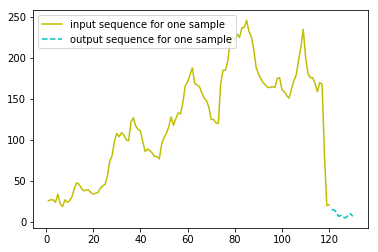

In [8]:
# draw an example of the generated data
input_dim = training_input_seqs.shape[1]
output_dim = training_output_seqs.shape[1]
x = np.linspace(1, input_dim + output_dim, input_dim + output_dim)
l1, = plt.plot(x[:input_dim], training_input_seqs[0], 'y', label = 'input sequence for one sample')
l2, = plt.plot(x[input_dim:], training_output_seqs[0], 'c--', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

## basic_rnn_seq2seq

In [9]:
from seq2seq_model import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 120
# length of output signals
output_seq_len = 10 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5
# tatal number of training data.
print("number of training data is %d" %(len(training_set)-input_seq_len-output_seq_len))

number of training data is 8109


## Training process

In [10]:
total_iteractions = 1000
batch_size = 256
KEEP_RATE = 0.5
train_losses = []
val_losses = []

# x = np.linspace(0, 30, 105)
# train_data_x = x[:85]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_training_data_for_seq2seq(ts, batch_size=batch_size, 
                                                                       input_seq_len=input_seq_len, output_seq_len=output_seq_len)
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        train_losses.append(loss_t)
        if i % 100 == 0:
            print("iteraction : %d/%d, loss is %d" %(i, total_iteractions, loss_t))
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

iteraction : 0/1000, loss is 52818
iteraction : 100/1000, loss is 9198
iteraction : 200/1000, loss is 10989
iteraction : 300/1000, loss is 7965
iteraction : 400/1000, loss is 9325
iteraction : 500/1000, loss is 10066
iteraction : 600/1000, loss is 3361
iteraction : 700/1000, loss is 4586
iteraction : 800/1000, loss is 4746
iteraction : 900/1000, loss is 4465
Checkpoint saved at:  ./univariate_ts_model0


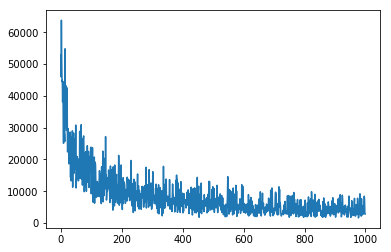

In [11]:
plt.plot(train_losses)

## Inference

In [12]:
# ts should come from dev set
test_input_seq, test_output_seq = generate_training_data_for_seq2seq(ts, batch_size=1, input_seq_len=input_seq_len, output_seq_len=output_seq_len)
test_input_seq = np.squeeze(test_input_seq)
test_output_seq = np.squeeze(test_output_seq)
print(test_input_seq.shape, test_output_seq.shape)

(120,) (10,)


In [13]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_input_seq[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


## Plot  predictions

In [17]:
final_preds = np.squeeze(final_preds)
print(final_preds.shape)

(10,)


In [18]:
x1 = len(test_input_seq)
x2 = len(test_input_seq)+len(test_output_seq)
print(x1, x2)

120 130


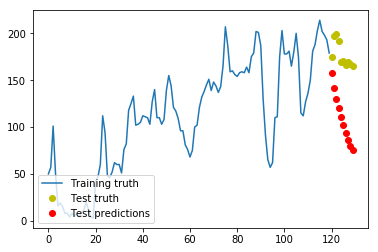

In [19]:
l1, = plt.plot(range(x1), test_input_seq, label = 'Training truth')
l2, = plt.plot(range(x1, x2), test_output_seq, 'yo', label = 'Test truth')
l3, = plt.plot(range(x1, x2), final_preds, 'ro', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()

## Eveluate

In [26]:
len(dev_set_list)

1929

In [28]:
rnn_model = build_graph(feed_previous=True)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    length = len(dev_set_list)
    smape = 0
    for i in range(len(dev_set_list)):
        dev_input_seq, dev_output_seq = dev_set_list[i]
        feed_dict = {rnn_model['enc_inp'][t]: dev_input_seq[t].reshape(1,1) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
        final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
        final_preds = np.concatenate(final_preds, axis = 1)
        r = symmetric_mean_absolute_percentage_error(dev_output_seq, final_preds) # SMAPE on a single time series
        smape += r
    
    smape = smape / length
    print("SMAPE value on the dev set is : ", smape)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0
SMAPE value on the dev set is :  0.493985392448
